<a href="https://colab.research.google.com/github/amitav710/SAiDl/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning

Importing the Libraries

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import argparse

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import math
from tensorflow.keras import layers
from tensorflow.keras.layers import (
 Conv2D,
 BatchNormalization,
 Dense,
 MaxPool2D,
 Flatten,
 Dropout,
 Add,
 ReLU
)

Loading and formatting datasets

In [39]:
ds_train, info_train = tfds.load('stl10', split='train', with_info=True, shuffle_files=True, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[189, 204, 235], [189, 204, 235], [189, 204,...",9


In [40]:
ds_test, info_test = tfds.load('stl10', split='test', with_info=True, shuffle_files=True, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[213, 214, 220], [219, 219, 225], [220, 221,...",9
1,"[[[31, 36, 32], [37, 42, 42], [60, 63, 60], [5...",3
2,"[[[87, 87, 74], [84, 86, 76], [80, 82, 75], [8...",3
3,"[[[37, 76, 22], [40, 79, 22], [43, 76, 25], [4...",1
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9


In [87]:
x_train=[]
y_train=[]
for data in ds_train:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_train.append(x)
  y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape

(5000, 96, 96, 3)

In [88]:
y_train = pd.get_dummies(y_train)
y_train.shape

(5000, 10)

In [89]:
x_test=[]
y_test=[]

for data in ds_test:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = pd.get_dummies(y_test)

In [90]:
x_test.shape

(8000, 96, 96, 3)

In [91]:
y_test.shape

(8000, 10)

Image augmentation

In [92]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [93]:
training_set = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

In [94]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

Making the CNN

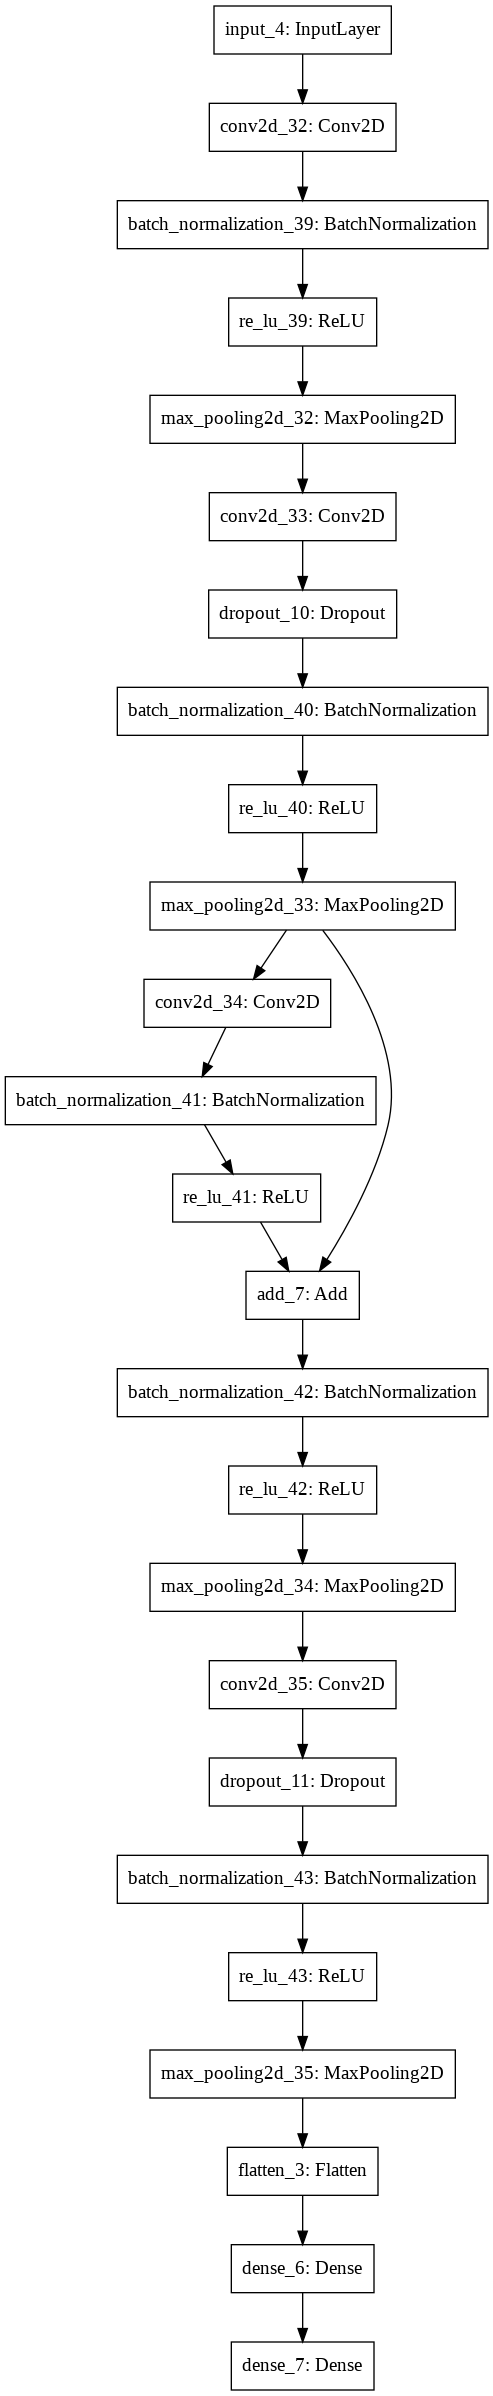

In [95]:
shape=(96,96,3)
input=layers.Input(shape)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x=(Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy1=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy2=x
x = Add()([x_copy1,x_copy2])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy3=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy4=x
x = Add()([x_copy3,x_copy4])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)
x = (Flatten())(x)
x = (Dense(128, activation = 'relu'))(x)
output = (Dense(units=10,activation = 'softmax'))(x)

cnn = tf.keras.Model(inputs=input, outputs=output)
plot_model(cnn)

In [101]:
stop = EarlyStopping(patience=30, monitor='val_loss', mode='min')

In [ ]:
"""initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.75
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate, 
  decay_steps, 
  decay_rate,
  staircase=True
)"""

Training the CNN

In [102]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0002)

In [103]:
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [104]:
model_checkpoint_callback = ModelCheckpoint('wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [100]:
cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 96, 96, 96)   2688        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 96, 96, 96)   384         conv2d_32[0][0]                  
__________________________________________________________________________________________________
re_lu_39 (ReLU)                 (None, 96, 96, 96)   0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

In [105]:
history=cnn.fit(x=training_set, validation_data=test_set, epochs= 120, batch_size=32, callbacks=[stop, model_checkpoint_callback])

Epoch 1/120
157/157 [==============================] - 17s 98ms/step - loss: 2.0635 - accuracy: 0.2788 - val_loss: 1.7197 - val_accuracy: 0.3697
Epoch 2/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 15s 98ms/step - loss: 1.6890 - accuracy: 0.3712 - val_loss: 1.5953 - val_accuracy: 0.4050
Epoch 3/120
157/157 [==============================] - 15s 96ms/step - loss: 1.5688 - accuracy: 0.4046 - val_loss: 1.4742 - val_accuracy: 0.4538
Epoch 4/120
157/157 [==============================] - 15s 96ms/step - loss: 1.4691 - accuracy: 0.4492 - val_loss: 1.3933 - val_accuracy: 0.4826
Epoch 5/120
157/157 [==============================] - 15s 95ms/step - loss: 1.4329 - accuracy: 0.4630 - val_loss: 1.3852 - val_accuracy: 0.4956
Epoch 6/120
157/157 [==============================] - 15s 97ms/step - loss: 1.3656 - accuracy: 0.5006 - val_loss: 1.3714 - val_accuracy: 0.4910
Epoch 7/120
157/157 [==============================] - 15s 97ms/step - loss: 1.3085 - accuracy: 0.5088 - val_loss: 1.2809 - val_accuracy: 0.5312
Epoch 8/120
157/157 [==============================] - 16s 100ms/step - loss: 1.2915 - accuracy: 0.5250 - val_loss: 1.2943 - val_accuracy: 0.5

Accuracy History

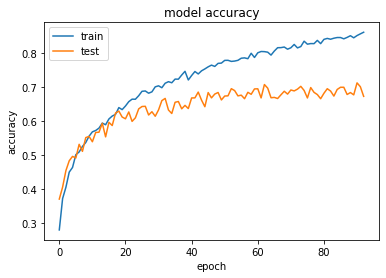

In [106]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss History

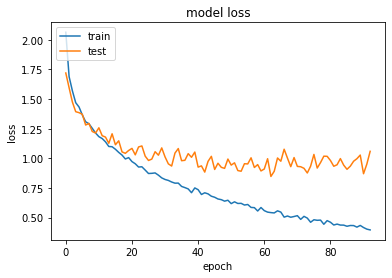

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
cnn.save('wts.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
